In [6]:
# General
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil

# pysynphot - work with spectra
import pysynphot as S

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

In [7]:
# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"

hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

In [8]:
# Prepare shape-defining equations
# GALAXY ellipses
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x,y,x_0,y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)

# STAR circle
gen_cirl = lambda x,y,x_0,y_0: (x-x_0)**2 + (y-y_0)**2

star_radius = lambda mag: 4663 * 10**(-0.1587 * mag) + 1.596 # + 1.596 # Roughly sketched in logger pro then doubled

In [9]:
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=empty_seg, pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [10]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

error_file = open("errors.txt", "a+")

for object in tqdm(hlss_tbl):
    
    # SEGMENTATION -------------------------------

    temp_seg = np.zeros((4088,4088))

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]
    modimage = object["MODIMAGE"]

    # STAR
    if modimage:
        radius = max(star_radius(mag), 8)
        circ = lambda x, y: gen_cirl(x, y, x_0, y_0)

        # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1)) # floor
        x_max = min(4087, int(x_0 + radius + 1) + 1) # ceil
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4087, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        condition = circ(x_grid, y_grid) <= radius

    # GALAXY
    else:
        a = object["A_IMAGE"]
        b = object["B_IMAGE"]
        theta = object["THETA_IMAGE"] * (np.pi / 180)
        radius = 3

      # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1))
        x_max = min(4087, int(x_0 + radius + 1) + 1)
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4087, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        ellipse = lambda x,y: gen_ellipse(x, y, x_0, y_0, (theta, a, b))
        condition = ellipse(x_grid, y_grid) <= radius

    temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id 

    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue
    roman_sim.seg = np.rot90(temp_seg,k=3).astype("float32")

    # SIMULATION ---------------------------------

    # STAR
    if object["MODIMAGE"]:
        sed_path = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/ukg0v.fits"
        file = fits.open(sed_path)
        wave = np.linspace(10000,20000,2000)
        flux = file[0].data[1770:3770]
        file.close()
        z = 0

    # GALAXY
    else:
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

    spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
    spec = spec.renorm(mag, "abmag", bp)
    spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

  0%|          | 10/10763 [00:00<14:30, 12.36it/s]

ID 51548 not found in segmentation image


  1%|          | 116/10763 [00:08<13:45, 12.89it/s]

ID 49277 not found in segmentation image


  1%|▏         | 141/10763 [00:10<11:23, 15.55it/s]

ID 136415 not found in segmentation image


  2%|▏         | 217/10763 [00:15<13:29, 13.03it/s]

ID 153228 not found in segmentation image


  2%|▏         | 239/10763 [00:17<13:57, 12.56it/s]

ID 74258 not found in segmentation image


  2%|▏         | 243/10763 [00:17<13:48, 12.70it/s]

ID 65012 not found in segmentation image


  2%|▏         | 245/10763 [00:18<13:40, 12.82it/s]

ID 94017 not found in segmentation image


  3%|▎         | 317/10763 [00:23<12:05, 14.40it/s]

ID 147220 not found in segmentation image


  3%|▎         | 349/10763 [00:25<13:23, 12.97it/s]

ID 168937 not found in segmentation image


  4%|▍         | 408/10763 [00:29<12:24, 13.91it/s]

ID 143059 not found in segmentation image


  4%|▍         | 417/10763 [00:30<10:21, 16.64it/s]

ID 63865 not found in segmentation image


  4%|▍         | 461/10763 [00:33<13:33, 12.66it/s]

ID 18697 not found in segmentation image


  5%|▍         | 493/10763 [00:36<13:23, 12.78it/s]

ID 172629 not found in segmentation image


  5%|▍         | 509/10763 [00:37<13:16, 12.87it/s]

ID 68195 not found in segmentation image


  5%|▍         | 535/10763 [00:39<12:47, 13.32it/s]

ID 19068 not found in segmentation image


  5%|▌         | 539/10763 [00:39<13:19, 12.79it/s]

ID 128513 not found in segmentation image


  6%|▌         | 650/10763 [00:47<13:03, 12.91it/s]

ID 855 not found in segmentation image


  6%|▋         | 677/10763 [00:49<13:24, 12.54it/s]

ID 42019 not found in segmentation image


  7%|▋         | 709/10763 [00:52<11:40, 14.35it/s]

ID 100346 not found in segmentation image


  7%|▋         | 775/10763 [00:57<11:31, 14.45it/s]

ID 102997 not found in segmentation image


  8%|▊         | 816/10763 [01:00<11:11, 14.81it/s]

ID 60547 not found in segmentation image


  9%|▊         | 918/10763 [01:07<12:56, 12.68it/s]

ID 78547 not found in segmentation image


  9%|▉         | 955/10763 [01:10<11:20, 14.41it/s]

ID 180045 not found in segmentation image


  9%|▉         | 957/10763 [01:10<12:00, 13.60it/s]

ID 115538 not found in segmentation image


  9%|▉         | 970/10763 [01:11<12:32, 13.02it/s]

ID 109731 not found in segmentation image


  9%|▉         | 974/10763 [01:12<12:56, 12.60it/s]

ID 98019 not found in segmentation image


  9%|▉         | 1003/10763 [01:14<13:05, 12.42it/s]

ID 154952 not found in segmentation image


  9%|▉         | 1017/10763 [01:15<12:49, 12.66it/s]

ID 168897 not found in segmentation image


 10%|▉         | 1067/10763 [01:19<13:15, 12.19it/s]

ID 74424 not found in segmentation image


 10%|█         | 1077/10763 [01:20<13:17, 12.14it/s]

ID 101642 not found in segmentation image


 10%|█         | 1122/10763 [01:23<13:05, 12.28it/s]

ID 64248 not found in segmentation image


 11%|█         | 1138/10763 [01:25<11:55, 13.46it/s]

ID 165173 not found in segmentation image


 11%|█         | 1154/10763 [01:26<12:51, 12.45it/s]

ID 162225 not found in segmentation image


 11%|█         | 1183/10763 [01:28<12:59, 12.29it/s]

ID 141191 not found in segmentation image


 11%|█         | 1193/10763 [01:29<10:56, 14.58it/s]

ID 187390 not found in segmentation image


 11%|█▏        | 1215/10763 [01:31<12:53, 12.35it/s]

ID 83874 not found in segmentation image


 12%|█▏        | 1266/10763 [01:35<11:28, 13.79it/s]

ID 155974 not found in segmentation image


 12%|█▏        | 1294/10763 [01:37<12:14, 12.88it/s]

ID 186038 not found in segmentation image


 12%|█▏        | 1310/10763 [01:38<12:55, 12.19it/s]

ID 19067 not found in segmentation image


 12%|█▏        | 1345/10763 [01:41<12:25, 12.63it/s]

ID 194116 not found in segmentation image


 13%|█▎        | 1378/10763 [01:44<12:31, 12.48it/s]

ID 150792 not found in segmentation image


 13%|█▎        | 1380/10763 [01:44<12:33, 12.46it/s]

ID 170524 not found in segmentation image


 13%|█▎        | 1388/10763 [01:44<12:27, 12.54it/s]

ID 136420 not found in segmentation image


 13%|█▎        | 1412/10763 [01:46<12:53, 12.09it/s]

ID 58945 not found in segmentation image


 14%|█▎        | 1459/10763 [01:50<12:37, 12.27it/s]

ID 45119 not found in segmentation image


 14%|█▍        | 1482/10763 [01:52<11:34, 13.37it/s]

ID 40762 not found in segmentation image


 14%|█▍        | 1494/10763 [01:53<12:59, 11.90it/s]

ID 131917 not found in segmentation image


 14%|█▍        | 1532/10763 [01:56<12:08, 12.67it/s]

ID 124920 not found in segmentation image


 14%|█▍        | 1538/10763 [01:56<12:24, 12.38it/s]

ID 4 not found in segmentation image


 15%|█▍        | 1594/10763 [02:01<12:45, 11.97it/s]

ID 94562 not found in segmentation image


 16%|█▌        | 1705/10763 [02:09<10:23, 14.54it/s]

ID 98942 not found in segmentation image


 16%|█▌        | 1717/10763 [02:10<11:46, 12.80it/s]

ID 114057 not found in segmentation image


 16%|█▌        | 1739/10763 [02:12<10:22, 14.50it/s]

ID 55810 not found in segmentation image


 16%|█▋        | 1760/10763 [02:13<11:54, 12.61it/s]

ID 18888 not found in segmentation image


 17%|█▋        | 1811/10763 [02:17<12:01, 12.40it/s]

ID 114061 not found in segmentation image


 18%|█▊        | 1941/10763 [02:28<11:48, 12.45it/s]

ID 22851 not found in segmentation image


 18%|█▊        | 1945/10763 [02:28<12:04, 12.17it/s]

ID 136421 not found in segmentation image


 18%|█▊        | 1988/10763 [02:32<11:36, 12.61it/s]

ID 145031 not found in segmentation image


 19%|█▉        | 2040/10763 [02:36<11:43, 12.40it/s]

ID 12129 not found in segmentation image


 19%|█▉        | 2048/10763 [02:36<11:34, 12.54it/s]

ID 155844 not found in segmentation image


 19%|█▉        | 2063/10763 [02:37<09:56, 14.59it/s]

ID 147226 not found in segmentation image


 19%|█▉        | 2073/10763 [02:38<11:53, 12.18it/s]

ID 75903 not found in segmentation image


 20%|██        | 2165/10763 [02:45<10:55, 13.11it/s]

ID 147230 not found in segmentation image
ID 192938 not found in segmentation image


 20%|██        | 2204/10763 [02:48<11:18, 12.61it/s]

ID 128514 not found in segmentation image


 21%|██        | 2220/10763 [02:50<11:37, 12.24it/s]

ID 36577 not found in segmentation image


 21%|██        | 2274/10763 [02:54<11:13, 12.61it/s]

ID 19200 not found in segmentation image


 21%|██▏       | 2292/10763 [02:55<11:37, 12.14it/s]

ID 5391 not found in segmentation image
ID 165064 not found in segmentation image


 22%|██▏       | 2337/10763 [02:59<11:15, 12.47it/s]

ID 153878 not found in segmentation image


 22%|██▏       | 2395/10763 [03:03<10:47, 12.93it/s]

ID 118984 not found in segmentation image


 23%|██▎       | 2438/10763 [03:07<10:29, 13.23it/s]

ID 69478 not found in segmentation image


 25%|██▍       | 2641/10763 [03:23<10:47, 12.55it/s]

ID 115539 not found in segmentation image


 25%|██▍       | 2645/10763 [03:23<10:50, 12.49it/s]

ID 20614 not found in segmentation image


 25%|██▌       | 2699/10763 [03:27<10:57, 12.27it/s]

ID 102979 not found in segmentation image


 26%|██▌       | 2751/10763 [03:32<08:33, 15.60it/s]

ID 11658 not found in segmentation image


 26%|██▌       | 2789/10763 [03:35<11:16, 11.78it/s]

ID 7235 not found in segmentation image


 26%|██▌       | 2804/10763 [03:36<10:00, 13.25it/s]

ID 159013 not found in segmentation image


 26%|██▋       | 2826/10763 [03:38<11:09, 11.86it/s]

ID 152817 not found in segmentation image


 27%|██▋       | 2927/10763 [03:46<10:42, 12.19it/s]

ID 35153 not found in segmentation image


 27%|██▋       | 2950/10763 [03:48<08:25, 15.45it/s]

ID 143055 not found in segmentation image


 28%|██▊       | 3006/10763 [03:52<10:45, 12.01it/s]

ID 25036 not found in segmentation image


 28%|██▊       | 3012/10763 [03:53<10:33, 12.24it/s]

ID 41786 not found in segmentation image


 28%|██▊       | 3022/10763 [03:54<10:40, 12.09it/s]

ID 167001 not found in segmentation image


 28%|██▊       | 3032/10763 [03:54<10:48, 11.92it/s]

ID 126746 not found in segmentation image


 28%|██▊       | 3043/10763 [03:55<09:42, 13.25it/s]

ID 189254 not found in segmentation image


 28%|██▊       | 3049/10763 [03:56<10:18, 12.47it/s]

ID 119353 not found in segmentation image


 28%|██▊       | 3053/10763 [03:56<10:17, 12.50it/s]

ID 39791 not found in segmentation image


 29%|██▉       | 3114/10763 [04:01<09:52, 12.92it/s]

ID 96886 not found in segmentation image


 29%|██▉       | 3173/10763 [04:06<10:21, 12.22it/s]

ID 19735 not found in segmentation image


 30%|██▉       | 3224/10763 [04:10<10:14, 12.28it/s]

ID 66 not found in segmentation image


 30%|███       | 3233/10763 [04:10<09:51, 12.72it/s]

ID 156746 not found in segmentation image


 30%|███       | 3272/10763 [04:14<10:16, 12.15it/s]

ID 75977 not found in segmentation image


 31%|███       | 3331/10763 [04:18<09:40, 12.79it/s]

ID 26324 not found in segmentation image


 31%|███▏      | 3374/10763 [04:22<08:53, 13.85it/s]

ID 187609 not found in segmentation image


 31%|███▏      | 3382/10763 [04:22<09:46, 12.59it/s]

ID 144873 not found in segmentation image


 32%|███▏      | 3439/10763 [04:27<08:42, 14.02it/s]

ID 163731 not found in segmentation image


 32%|███▏      | 3449/10763 [04:27<09:51, 12.37it/s]

ID 72214 not found in segmentation image


 32%|███▏      | 3451/10763 [04:27<09:56, 12.27it/s]

ID 102073 not found in segmentation image


 33%|███▎      | 3551/10763 [04:35<09:34, 12.56it/s]

ID 59380 not found in segmentation image


 33%|███▎      | 3571/10763 [04:37<10:15, 11.68it/s]

ID 149068 not found in segmentation image


 33%|███▎      | 3575/10763 [04:37<10:06, 11.86it/s]

ID 167224 not found in segmentation image


 33%|███▎      | 3583/10763 [04:38<09:56, 12.03it/s]

ID 25035 not found in segmentation image


 34%|███▍      | 3696/10763 [04:47<09:36, 12.26it/s]

ID 84036 not found in segmentation image


 35%|███▍      | 3716/10763 [04:49<09:22, 12.52it/s]

ID 113242 not found in segmentation image
ID 147658 not found in segmentation image


 35%|███▌      | 3781/10763 [04:54<09:19, 12.48it/s]

ID 171316 not found in segmentation image


 36%|███▌      | 3834/10763 [04:59<09:36, 12.03it/s]

ID 174379 not found in segmentation image


 36%|███▋      | 3925/10763 [05:06<08:40, 13.14it/s]

ID 102805 not found in segmentation image


 37%|███▋      | 3961/10763 [05:09<08:55, 12.69it/s]

ID 120258 not found in segmentation image


 37%|███▋      | 3990/10763 [05:11<09:28, 11.90it/s]

ID 80484 not found in segmentation image


 38%|███▊      | 4121/10763 [05:21<08:11, 13.52it/s]

ID 149760 not found in segmentation image


 38%|███▊      | 4143/10763 [05:23<09:05, 12.15it/s]

ID 4681 not found in segmentation image


 39%|███▊      | 4170/10763 [05:25<08:20, 13.17it/s]

ID 55806 not found in segmentation image


 39%|███▉      | 4204/10763 [05:28<08:37, 12.66it/s]

ID 147219 not found in segmentation image


 39%|███▉      | 4233/10763 [05:30<07:57, 13.67it/s]

ID 194299 not found in segmentation image


 40%|███▉      | 4300/10763 [05:35<08:53, 12.11it/s]

ID 157658 not found in segmentation image


 40%|████      | 4314/10763 [05:37<09:14, 11.64it/s]

ID 147229 not found in segmentation image


 40%|████      | 4357/10763 [05:40<08:28, 12.59it/s]

ID 115677 not found in segmentation image
ID 138908 not found in segmentation image


 41%|████      | 4365/10763 [05:41<08:38, 12.34it/s]

ID 174774 not found in segmentation image


 41%|████      | 4407/10763 [05:44<07:59, 13.27it/s]

ID 19078 not found in segmentation image


 41%|████      | 4429/10763 [05:46<08:44, 12.08it/s]

ID 138019 not found in segmentation image


 41%|████▏     | 4457/10763 [05:48<08:45, 12.00it/s]

ID 132377 not found in segmentation image


 41%|████▏     | 4461/10763 [05:49<08:39, 12.13it/s]

ID 95281 not found in segmentation image


 42%|████▏     | 4467/10763 [05:49<08:39, 12.12it/s]

ID 124515 not found in segmentation image


 42%|████▏     | 4477/10763 [05:50<08:20, 12.57it/s]

ID 40708 not found in segmentation image


 42%|████▏     | 4495/10763 [05:51<08:48, 11.87it/s]

ID 158957 not found in segmentation image


 42%|████▏     | 4549/10763 [05:56<08:18, 12.48it/s]

ID 130246 not found in segmentation image


 42%|████▏     | 4563/10763 [05:57<08:27, 12.22it/s]

ID 96740 not found in segmentation image


 43%|████▎     | 4575/10763 [05:58<07:10, 14.38it/s]

ID 68097 not found in segmentation image


 43%|████▎     | 4633/10763 [06:02<08:15, 12.37it/s]

ID 67943 not found in segmentation image
ID 102982 not found in segmentation image


 44%|████▍     | 4712/10763 [06:09<08:00, 12.59it/s]

ID 862 not found in segmentation image


 44%|████▍     | 4786/10763 [06:15<07:52, 12.66it/s]

ID 184716 not found in segmentation image


 45%|████▍     | 4792/10763 [06:15<08:04, 12.32it/s]

ID 68200 not found in segmentation image


 45%|████▍     | 4806/10763 [06:16<07:52, 12.59it/s]

ID 173798 not found in segmentation image


 45%|████▍     | 4837/10763 [06:19<07:40, 12.86it/s]

ID 139278 not found in segmentation image
ID 20616 not found in segmentation image


 45%|████▌     | 4867/10763 [06:21<07:43, 12.72it/s]

ID 101083 not found in segmentation image
ID 20763 not found in segmentation image


 46%|████▌     | 4907/10763 [06:24<08:06, 12.04it/s]

ID 176355 not found in segmentation image


 46%|████▌     | 4947/10763 [06:28<08:09, 11.89it/s]

ID 158956 not found in segmentation image


 46%|████▋     | 4982/10763 [06:31<09:03, 10.64it/s]

ID 50160 not found in segmentation image


 47%|████▋     | 5009/10763 [06:33<06:51, 13.98it/s]

ID 180464 not found in segmentation image
ID 68087 not found in segmentation image


 47%|████▋     | 5017/10763 [06:34<07:45, 12.36it/s]

ID 172389 not found in segmentation image


 47%|████▋     | 5049/10763 [06:36<05:48, 16.38it/s]

ID 112640 not found in segmentation image


 47%|████▋     | 5091/10763 [06:40<07:07, 13.27it/s]

ID 189658 not found in segmentation image


 47%|████▋     | 5102/10763 [06:40<07:36, 12.41it/s]

ID 117592 not found in segmentation image


 48%|████▊     | 5163/10763 [06:45<07:09, 13.03it/s]

ID 23962 not found in segmentation image


 49%|████▉     | 5251/10763 [06:52<07:22, 12.45it/s]

ID 124513 not found in segmentation image


 50%|████▉     | 5347/10763 [07:00<07:22, 12.24it/s]

ID 83457 not found in segmentation image


 51%|█████     | 5458/10763 [07:08<06:51, 12.90it/s]

ID 39776 not found in segmentation image


 52%|█████▏    | 5544/10763 [07:15<07:10, 12.12it/s]

ID 69480 not found in segmentation image


 52%|█████▏    | 5556/10763 [07:16<07:07, 12.19it/s]

ID 12140 not found in segmentation image


 52%|█████▏    | 5564/10763 [07:17<07:11, 12.04it/s]

ID 154858 not found in segmentation image


 52%|█████▏    | 5613/10763 [07:21<06:55, 12.39it/s]

ID 159003 not found in segmentation image


 53%|█████▎    | 5679/10763 [07:26<06:53, 12.29it/s]

ID 166527 not found in segmentation image


 53%|█████▎    | 5689/10763 [07:27<06:54, 12.24it/s]

ID 96436 not found in segmentation image


 53%|█████▎    | 5756/10763 [07:32<06:05, 13.70it/s]

ID 143051 not found in segmentation image


 53%|█████▎    | 5758/10763 [07:32<06:13, 13.42it/s]

ID 135438 not found in segmentation image


 54%|█████▎    | 5776/10763 [07:34<05:43, 14.53it/s]

ID 34991 not found in segmentation image


 54%|█████▍    | 5786/10763 [07:34<06:21, 13.06it/s]

ID 190832 not found in segmentation image


 54%|█████▍    | 5792/10763 [07:35<06:34, 12.60it/s]

ID 548 not found in segmentation image


 54%|█████▍    | 5808/10763 [07:36<06:41, 12.33it/s]

ID 78542 not found in segmentation image


 54%|█████▍    | 5853/10763 [07:40<06:21, 12.86it/s]

ID 155142 not found in segmentation image


 55%|█████▍    | 5867/10763 [07:41<06:25, 12.70it/s]

ID 40780 not found in segmentation image


 56%|█████▌    | 6040/10763 [07:54<06:04, 12.94it/s]

ID 88953 not found in segmentation image


 57%|█████▋    | 6142/10763 [08:02<05:20, 14.40it/s]

ID 65 not found in segmentation image


 57%|█████▋    | 6169/10763 [08:04<05:52, 13.03it/s]

ID 112513 not found in segmentation image


 58%|█████▊    | 6245/10763 [08:09<05:30, 13.65it/s]

ID 13327 not found in segmentation image


 59%|█████▉    | 6347/10763 [08:17<05:06, 14.39it/s]

ID 135506 not found in segmentation image


 61%|██████    | 6531/10763 [08:31<05:17, 13.33it/s]

ID 114388 not found in segmentation image


 61%|██████    | 6566/10763 [08:33<05:30, 12.68it/s]

ID 90780 not found in segmentation image


 62%|██████▏   | 6677/10763 [08:41<05:05, 13.40it/s]

ID 143077 not found in segmentation image


 62%|██████▏   | 6687/10763 [08:42<05:09, 13.16it/s]

ID 171930 not found in segmentation image


 62%|██████▏   | 6716/10763 [08:44<05:03, 13.34it/s]

ID 149983 not found in segmentation image
ID 180657 not found in segmentation image


 64%|██████▎   | 6845/10763 [08:54<05:05, 12.83it/s]

ID 115537 not found in segmentation image


 64%|██████▍   | 6880/10763 [08:57<04:38, 13.95it/s]

ID 103017 not found in segmentation image


 65%|██████▌   | 7013/10763 [09:06<03:53, 16.08it/s]

ID 59260 not found in segmentation image


 65%|██████▌   | 7021/10763 [09:07<04:31, 13.79it/s]

ID 47031 not found in segmentation image


 66%|██████▌   | 7072/10763 [09:11<04:27, 13.80it/s]

ID 93975 not found in segmentation image


 66%|██████▌   | 7105/10763 [09:13<04:06, 14.84it/s]

ID 18582 not found in segmentation image


 66%|██████▌   | 7125/10763 [09:15<04:09, 14.59it/s]

ID 37557 not found in segmentation image


 67%|██████▋   | 7253/10763 [09:24<04:17, 13.65it/s]

ID 31769 not found in segmentation image


 68%|██████▊   | 7315/10763 [09:29<04:26, 12.93it/s]

ID 96885 not found in segmentation image


 68%|██████▊   | 7321/10763 [09:30<04:22, 13.10it/s]

ID 195034 not found in segmentation image


 68%|██████▊   | 7338/10763 [09:31<04:01, 14.17it/s]

ID 67604 not found in segmentation image


 69%|██████▉   | 7401/10763 [09:36<04:14, 13.20it/s]

ID 175974 not found in segmentation image


 69%|██████▉   | 7419/10763 [09:37<04:25, 12.61it/s]

ID 178686 not found in segmentation image


 70%|██████▉   | 7523/10763 [09:45<04:13, 12.77it/s]

ID 79259 not found in segmentation image


 70%|███████   | 7572/10763 [09:48<03:51, 13.77it/s]

ID 74423 not found in segmentation image


 71%|███████   | 7629/10763 [09:52<03:32, 14.73it/s]

ID 83534 not found in segmentation image


 71%|███████   | 7641/10763 [09:53<03:58, 13.10it/s]

ID 175973 not found in segmentation image


 72%|███████▏  | 7728/10763 [10:00<03:47, 13.36it/s]

ID 117931 not found in segmentation image


 72%|███████▏  | 7746/10763 [10:01<03:48, 13.19it/s]

ID 172630 not found in segmentation image


 72%|███████▏  | 7791/10763 [10:05<03:46, 13.14it/s]

ID 63062 not found in segmentation image


 73%|███████▎  | 7840/10763 [10:08<03:41, 13.20it/s]

ID 11659 not found in segmentation image


 73%|███████▎  | 7866/10763 [10:10<03:36, 13.36it/s]

ID 169422 not found in segmentation image


 74%|███████▎  | 7929/10763 [10:15<03:36, 13.07it/s]

ID 90712 not found in segmentation image


 74%|███████▍  | 7981/10763 [10:19<03:24, 13.61it/s]

ID 63841 not found in segmentation image


 74%|███████▍  | 7985/10763 [10:19<03:26, 13.43it/s]

ID 114054 not found in segmentation image


 74%|███████▍  | 7993/10763 [10:20<03:34, 12.92it/s]

ID 112641 not found in segmentation image


 74%|███████▍  | 7997/10763 [10:20<03:31, 13.07it/s]

ID 68086 not found in segmentation image


 74%|███████▍  | 8015/10763 [10:21<03:31, 12.97it/s]

ID 56563 not found in segmentation image


 75%|███████▍  | 8029/10763 [10:22<03:00, 15.12it/s]

ID 72799 not found in segmentation image


 75%|███████▍  | 8041/10763 [10:23<03:24, 13.31it/s]

ID 15120 not found in segmentation image


 75%|███████▌  | 8121/10763 [10:29<03:19, 13.24it/s]

ID 119446 not found in segmentation image


 76%|███████▌  | 8159/10763 [10:32<03:16, 13.28it/s]

ID 51446 not found in segmentation image


 76%|███████▌  | 8178/10763 [10:34<02:55, 14.74it/s]

ID 151395 not found in segmentation image


 77%|███████▋  | 8234/10763 [10:38<03:09, 13.37it/s]

ID 37451 not found in segmentation image


 77%|███████▋  | 8242/10763 [10:38<03:13, 13.05it/s]

ID 172146 not found in segmentation image


 77%|███████▋  | 8252/10763 [10:39<03:08, 13.33it/s]

ID 68088 not found in segmentation image


 77%|███████▋  | 8275/10763 [10:41<03:04, 13.52it/s]

ID 10876 not found in segmentation image


 77%|███████▋  | 8335/10763 [10:45<03:06, 13.02it/s]

ID 18396 not found in segmentation image


 78%|███████▊  | 8412/10763 [10:51<02:55, 13.39it/s]

ID 111170 not found in segmentation image


 79%|███████▉  | 8498/10763 [10:58<02:52, 13.09it/s]

ID 104810 not found in segmentation image


 79%|███████▉  | 8520/10763 [10:59<02:46, 13.44it/s]

ID 170200 not found in segmentation image


 79%|███████▉  | 8548/10763 [11:02<02:45, 13.38it/s]

ID 39779 not found in segmentation image
ID 143906 not found in segmentation image


 80%|███████▉  | 8580/10763 [11:04<02:49, 12.91it/s]

ID 102977 not found in segmentation image
ID 129233 not found in segmentation image


 80%|███████▉  | 8610/10763 [11:06<02:43, 13.16it/s]

ID 94561 not found in segmentation image


 82%|████████▏ | 8797/10763 [11:20<02:28, 13.21it/s]

ID 114389 not found in segmentation image


 82%|████████▏ | 8858/10763 [11:25<02:23, 13.24it/s]

ID 61981 not found in segmentation image


 83%|████████▎ | 8886/10763 [11:27<02:21, 13.31it/s]

ID 125905 not found in segmentation image


 83%|████████▎ | 8890/10763 [11:27<02:22, 13.17it/s]

ID 147222 not found in segmentation image


 83%|████████▎ | 8913/10763 [11:29<02:17, 13.42it/s]

ID 50122 not found in segmentation image


 83%|████████▎ | 8986/10763 [11:35<02:11, 13.51it/s]

ID 8774 not found in segmentation image


 84%|████████▍ | 9023/10763 [11:37<02:12, 13.17it/s]

ID 69477 not found in segmentation image


 84%|████████▍ | 9029/10763 [11:38<02:10, 13.29it/s]

ID 39780 not found in segmentation image


 84%|████████▍ | 9063/10763 [11:40<02:07, 13.30it/s]

ID 143054 not found in segmentation image
ID 180465 not found in segmentation image


 85%|████████▍ | 9101/10763 [11:43<02:03, 13.41it/s]

ID 169423 not found in segmentation image


 85%|████████▍ | 9115/10763 [11:44<02:03, 13.34it/s]

ID 72285 not found in segmentation image


 85%|████████▍ | 9135/10763 [11:46<02:01, 13.36it/s]

ID 147234 not found in segmentation image


 85%|████████▌ | 9161/10763 [11:48<01:59, 13.36it/s]

ID 16458 not found in segmentation image
ID 102957 not found in segmentation image


 85%|████████▌ | 9183/10763 [11:50<02:03, 12.78it/s]

ID 96517 not found in segmentation image


 85%|████████▌ | 9193/10763 [11:50<01:58, 13.20it/s]

ID 55162 not found in segmentation image


 86%|████████▌ | 9220/10763 [11:52<01:55, 13.32it/s]

ID 134473 not found in segmentation image


 86%|████████▌ | 9281/10763 [11:57<01:51, 13.26it/s]

ID 7953 not found in segmentation image


 87%|████████▋ | 9385/10763 [12:05<01:44, 13.23it/s]

ID 177782 not found in segmentation image


 87%|████████▋ | 9407/10763 [12:06<01:44, 12.98it/s]

ID 120040 not found in segmentation image
ID 147223 not found in segmentation image


 88%|████████▊ | 9425/10763 [12:08<01:43, 12.87it/s]

ID 169089 not found in segmentation image


 88%|████████▊ | 9451/10763 [12:10<01:40, 13.00it/s]

ID 59885 not found in segmentation image


 88%|████████▊ | 9459/10763 [12:10<01:38, 13.23it/s]

ID 151364 not found in segmentation image


 88%|████████▊ | 9488/10763 [12:12<01:38, 12.97it/s]

ID 102978 not found in segmentation image
ID 10885 not found in segmentation image


 88%|████████▊ | 9506/10763 [12:14<01:37, 12.89it/s]

ID 71927 not found in segmentation image


 89%|████████▉ | 9576/10763 [12:19<01:28, 13.35it/s]

ID 94563 not found in segmentation image


 89%|████████▉ | 9578/10763 [12:19<01:32, 12.88it/s]

ID 180228 not found in segmentation image


 89%|████████▉ | 9584/10763 [12:20<01:31, 12.94it/s]

ID 47238 not found in segmentation image


 89%|████████▉ | 9616/10763 [12:22<01:26, 13.26it/s]

ID 62056 not found in segmentation image


 89%|████████▉ | 9630/10763 [12:23<01:25, 13.32it/s]

ID 137936 not found in segmentation image


 91%|█████████ | 9749/10763 [12:32<01:18, 12.86it/s]

ID 32922 not found in segmentation image


 92%|█████████▏| 9858/10763 [12:40<01:08, 13.29it/s]

ID 102072 not found in segmentation image


 92%|█████████▏| 9888/10763 [12:43<01:06, 13.16it/s]

ID 62130 not found in segmentation image


 92%|█████████▏| 9936/10763 [12:46<01:03, 13.00it/s]

ID 113170 not found in segmentation image
ID 63402 not found in segmentation image


 92%|█████████▏| 9940/10763 [12:47<01:02, 13.19it/s]

ID 178508 not found in segmentation image


 93%|█████████▎| 9966/10763 [12:48<01:00, 13.23it/s]

ID 121356 not found in segmentation image


 93%|█████████▎| 10001/10763 [12:51<00:57, 13.19it/s]

ID 18236 not found in segmentation image


 94%|█████████▎| 10080/10763 [12:57<00:51, 13.21it/s]

ID 49996 not found in segmentation image


 94%|█████████▍| 10106/10763 [12:59<00:49, 13.36it/s]

ID 82478 not found in segmentation image


 94%|█████████▍| 10120/10763 [13:00<00:49, 12.88it/s]

ID 175642 not found in segmentation image


 95%|█████████▍| 10196/10763 [13:06<00:42, 13.23it/s]

ID 208537 not found in segmentation image


 95%|█████████▍| 10214/10763 [13:07<00:39, 13.74it/s]

ID 209435 not found in segmentation image


 95%|█████████▌| 10232/10763 [13:08<00:39, 13.51it/s]

ID 207584 not found in segmentation image


 96%|█████████▌| 10294/10763 [13:13<00:34, 13.53it/s]

ID 206620 not found in segmentation image


 96%|█████████▌| 10298/10763 [13:13<00:34, 13.38it/s]

ID 206539 not found in segmentation image


 96%|█████████▋| 10362/10763 [13:18<00:29, 13.43it/s]

ID 206217 not found in segmentation image


 97%|█████████▋| 10406/10763 [13:21<00:26, 13.70it/s]

ID 204754 not found in segmentation image


 97%|█████████▋| 10462/10763 [13:26<00:22, 13.14it/s]

ID 204213 not found in segmentation image


 98%|█████████▊| 10534/10763 [13:31<00:16, 13.75it/s]

ID 202345 not found in segmentation image


 98%|█████████▊| 10548/10763 [13:32<00:15, 13.46it/s]

ID 201239 not found in segmentation image


 98%|█████████▊| 10560/10763 [13:33<00:15, 13.30it/s]

ID 201690 not found in segmentation image


 98%|█████████▊| 10594/10763 [13:35<00:12, 13.67it/s]

ID 200968 not found in segmentation image


 99%|█████████▉| 10656/10763 [13:40<00:07, 13.42it/s]

ID 199455 not found in segmentation image


100%|█████████▉| 10742/10763 [13:46<00:01, 13.52it/s]

ID 197736 not found in segmentation image


100%|██████████| 10763/10763 [13:48<00:00, 12.99it/s]


In [11]:
sim_min = roman_sim.model.min()
sim_max = roman_sim.model.max()
sim_median = np.median(roman_sim.model[723:1723, 1624:2624])

print(f"min: {sim_min}", f"max: {sim_max}", f"median: {sim_median}", sep='\n')

min: 0.0
max: 160.66757202148438
median: 0.013278299942612648


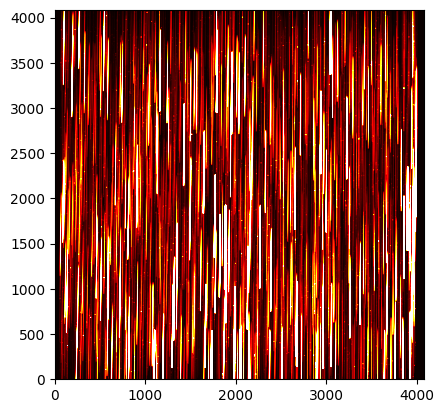

In [12]:
fig, ax = plt.subplots()

upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
ax.imshow(upright_img, origin='lower', vmin=0, vmax=0.11738539732765789, cmap='hot')

In [13]:
save_to_filename = "integrated_sim.fits"

file = fits.open(direct_file)
header = file[1].header
PrimaryHDU = file[0]

ImageHDU = fits.ImageHDU(data=upright_img, header=header, name="SCI")
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name="ERR")
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name="DQ")

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto(save_to_filename, overwrite=True)

file.close()